# MNIST Assignment

This is the notebook for the MNIST Assignment given in the exercises section of classification notebook.
We need to perform the following tasks: -
1. Try to build a classifier for the MNIST datasets that achieves over 97% accuracy on the test set. Hint: The KNeighborsClassifier works well for this task: you need to find good hyperparameter values (try using grid search on weights and n_neighbors hyperparameters).
2. Write a function that can shift an MNIST image in any direction (left, right, up, down) by 1 pixel. The for each image in the training set create four shifted copies and add them to the training set. Finally, train your best model on the expanded training set and measure accuracy on test set, This should make the model work better, technique is called data augmentation or training set expansion.

In [1]:
# Importing the dataset

from sklearn.datasets import fetch_openml

data = fetch_openml('mnist_784',version=1)
data

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

In [2]:
data.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# Extract feature and target variables

X = data['data']
y = data['target']
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
X.shape, y.shape
# Let's start off by visualising our data

# Convert to ndarray so that we can use reshape
image = X.loc[0].to_numpy()

#reshape our image to our format of 28x28
image = image.reshape(28, 28)

Text(0.5, 1.0, '5')

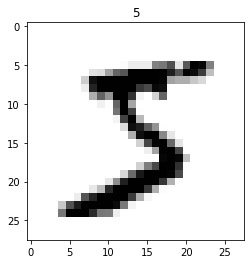

In [5]:
# Import necessary library to plot images

import matplotlib.pyplot as plt

plt.imshow(image, cmap='binary')
plt.title(y[0])

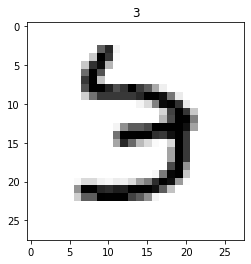

In [6]:
# Now we can visualise our data, lets create a plot to visualise a random image from the data
from random import randint

def plot_random_img():
    index = randint(0, len(X))  # gives a random image index
    img = X.loc[index].to_numpy()
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='binary')
    plt.title(y[index])


# Call this function
plot_random_img()

In [7]:
# Let's now see what max and min of our pixel values are
max(X.loc[0]), min(X.loc[0])

(255.0, 0.0)

In [8]:
# We already know that machine learning models work better when we scale them so lets do that

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

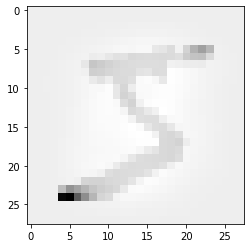

In [9]:
img = X_scaled[0]
img = img.reshape(28, 28)
plt.imshow(img, cmap='binary')

In [10]:
# Split our data into train and test sets
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True)

## Creating our KNN Model

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score

mnist_knn_1 = KNeighborsClassifier()
mnist_knn_1.fit(X_train, y_train)

# Score 
score_1 = cross_val_score(mnist_knn_1, X_train, y_train, cv=3)  # we dont score it on test data as that is reserved for final testing

# Make predictions 
y_preds_1 = cross_val_predict(mnist_knn_1, X_train, y_train, cv=3)  # same reason as for score

print(f"Score of basic knn model: {score_1}")

Score of basic knn model: [0.93962608 0.9385011  0.93828351]


In [12]:
# Lets check the confusion matrix

from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
f1_1 = f1_score(y_train, y_preds_1, average=None)
cfm1 = confusion_matrix(y_train, y_preds_1)
print(f"F1-Score: {f1_1}")
print(f"Confusion Matrix: {cfm1}")

F1-Score: [0.96966978 0.96797426 0.93682114 0.92999391 0.93581206 0.91631882
 0.96229963 0.93179487 0.91924266 0.91006808]
Confusion Matrix: [[5403    6   11    7    4   12   31    4    1    4]
 [   1 6317   18    5    7    1   21    5    4    2]
 [  69   65 5175   96   23    8   53   46   40   13]
 [  13   22   62 5347    5   79    7   60   50   31]
 [   3   64   54    5 5059   15   26   30    8  186]
 [  38   14   16  162   21 4610   91   14   40   45]
 [  59   11   20    3   12   49 5373    1    6    0]
 [  10   70   39   15   74    7    1 5451    3  186]
 [  38   86   41  126   44  215   30   26 4758   58]
 [  27   16   24   57  113   15    0  207   20 5080]]


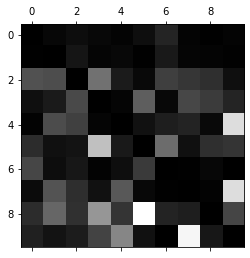

In [13]:
import numpy as np
rows = cfm1.sum(keepdims=True)
norm_cfm1 = cfm1 / rows

# FIll diagonals with 0 to keep errors
np.fill_diagonal(norm_cfm1, 0)
plt.matshow(norm_cfm1, cmap=plt.cm.gray)
plt.show()

## Improving model performance using grid search

In [20]:
# We use grid search to find the best values for the hyperparameters for our model
'''from sklearn.model_selection import GridSearchCV


mnist_knn_2 = KNeighborsClassifier()
params = {'n_neighbors': [i for i in range(10,30)]}
clf = GridSearchCV(mnist_knn_1, param_grid=params)
res = clf.fit(X_train, y_train)'''

In [21]:
'res'

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28,
                                         29]})

In [22]:
'res.best_params_'

{'n_neighbors': 10}

Therefore we found the best parameters are with 4 neighbours and the weights as distance

In [23]:
mnist_knn_2 = KNeighborsClassifier(weights='distance', n_neighbors=10)
mnist_knn_2.fit(X_train, y_train)
# Score 
score_2 = cross_val_score(mnist_knn_2, X_train, y_train, cv=3)  # we dont score it on test data as that is reserved for final testing

# Make predictions 
y_preds_2 = cross_val_predict(mnist_knn_2, X_train, y_train, cv=3)  # same reason as for score

print(f"Score of basic knn model: {score_2}")

Score of basic knn model: [0.94016178 0.93641185 0.93764063]


In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_preds_2)

0.9434464285714286

In [19]:
y_preds_3 = mnist_knn_2.predict(X_test)
accuracy_score(y_test, y_preds_3)

0.9536428571428571